# Дисклеймер
Эту тетрадку лучше запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

In [72]:
# !pip install pandas scikit-learn gensim matplotlib

## Введение в нейронные сети 

Все задачи, которые мы решали до этого, можно решать с помощью нейронных сетей. Часто нейронные сети будут наилучшим выбором, особенно когда у нас текстовые или картиночные данные и их достаточно много (примерно от 50к). Но в любом случае, перед тем как доставать нейронки лучше прогнать несколько стандартных моделей. Часто они решат задачу на приемлимом уровне и время, затраченное на обучение нейронки, не окупит себя. Также с табличными данными лучше просто использовать бустинги.

Для написания нейронок есть два основных фреймворка -  tensorflow и pytorch. Сказать, что лучше, тяжело. В целом, тензорфлоу с встроенным keras (раньше был отдельным фреймворком) сильно проще для новичков, но многое в нём происходит "под капотом". Когда все работает это даже хорошо, но когда что-то ломается, очень сложно понять, что именно.  Pytorch сложнее в освоении и многие вещи там приходится делать вручную, но это заставляет разобраться в технических деталях и дает большую свободу. 

В наших занятиях мы попробуем tensorflow.

In [1]:
import tensorflow as tf

Для наглядности возьмем две разные задачи - классификации и регресии. В обоих задачах мы будем работать с текстом и по большей части весь пайплайн у нас будет одинаков. Отличаться будут только последние штрихи в самих моделях.

## Регрессия на данных Avito

Данные из соревнования - https://www.kaggle.com/c/avito-demand-prediction/overview  
Я взял только поле description, так как наша задача разобраться с нейронками, а не добиться самого большого качества.

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

Во всех предыдущих семинарах мы обрезали данные Авито, так как модели не могли столько переварить. В случае нейронок такой проблемы нет, модель обучается на батчах (кусках данных) и можно использовать неограниченное количество данных. Но для семинара будет слишком долго обучаться, поэтому пока тоже возьмем только 10 %.

In [3]:
avito = pd.read_csv('avito_data.csv').dropna().sample(frac=0.1)

In [28]:
avito

,description,deal_probability
1056015,очень игривая ласковая девочка кличка Рада про...,0.09346
675100,"Тетрадь ""Проверим себя "" 4 класс,окружающий ми...",0.00000
729638,Если у ваших близких или друзей намечается важ...,0.35468
286811,"Страна вывоза Объединённые Арабские Эмираты,Ст...",0.73760
263617,Очки в отличном состоянии!/\nОправа итальянска...,0.00000
...,...,...
1497885,развивающие игрушки и погремушки. в отличном с...,0.00000
770848,Продам утепленный комбинезон на мальчика. Разм...,0.00000
1414269,Monnalisa 30размер. Абсолютно новые. Пересыл,0.00000
367424,В идеальном состоянии. Не бита не крашена. Сиг...,0.73760


Предобработка нам не так важна. Главное - получить из текстов токены.

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

Теперь нам нужно собрать все уникальные слова в словарь. Лучше сразу посчитать количество упоминаний, чтобы отсеять самые редкие.

Теперь нам нужно заменить в каждом тексте слова на числа (индексы в словаре). 

Создадим для этого специальный словарь с индексами. В этот словарь нам нужно положить дополнительный токен - PAD (чуть ниже станет понятнее)

In [35]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [6]:
vocab = Counter()

for text in avito.description:
    vocab.update(preprocess(text))

почти 300к слов - это много, учитывая, что это только 10% данных

In [7]:
len(vocab)

284191

Возьмем только те, что встретились больше 30 раз.

In [8]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

11к - уже нормальная цифра

В нашей задаче нам не понадобится раскодировать индексы, но если бы мы делали языковую модель, нам бы понадобился ещё и обратный словарь.

In [36]:
id2word = {i:word for word, i in word2id.items()}

Заменяем слова на индексы.

In [37]:

X = []

for text in avito.description:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

А теперь про паддинг. 

Все тексты в нашем трейне разной длины и это проблема, так как модель ожидает последовательности одной длины. Для этого есть паддинг - т.е. забивание последовательности нулями до определенной длинны (мы не просто так присвоили PAD нулевой индекс - это важно)

Лучше всего сделать паддиг до самого длинного текста, но это зачастую не оптимально или даже невозможно из-за нехватки ресурсов. Поэтому значение паддинга приходится подбирать на глаз. 

Пояснение: если значение паддинга меньше длины текста, то этот текст обрежется.

In [38]:
MAX_LEN = max(len(x) for x in X)

700 - довольно мого, довайте попробуем поменьше.

In [39]:
MAX_LEN

564

In [40]:
MAX_LEN = 100

In [41]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [42]:
X.shape

(138715, 100)

Мы почти готовы к обучению. Осталось достать таргет и разбить выборку на трейн и тест.

In [43]:
y = avito.deal_probability.values

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

Теперь сама модель. В tf.keras два способа построения моделей: Sequential и Functional. В первом мы как будто создаем список и добавляем в него слои, а во втором вручную применяем каждый слой к результату предыдущего слоя.

### Sequential

In [45]:
model = tf.keras.Sequential()
# первым добавляем эмбединг слой
# он каждому слову сопоставит вектор заданой размерности
# также нам нужно передать параметры нашей выборки - размер словаря (input_dim) и длинну текста (input_length)
model.add(tf.keras.layers.Embedding(input_dim=len(word2id), 
                                    input_length=MAX_LEN, output_dim=100))

# вообще для работы с последовательностями нужно использовать рекурентные или сверточные слои
# но с ними мы познакомимся в следующий раз
# Пока, чтобы получить один вектор из последовательности векторов,
# просто склеим их в один 
model.add(tf.keras.layers.Flatten())

# теперь можно добавить любое количество полносвязных слоев, но не обязательно
# model.add(tf.keras.layers.Dense(100, activation='relu'))

# теперь последний слой, выход которого и будет предсказанием
# тут нужно указать количество классов и функцию активации
# в задаче регрессии мы предсказываем одно число == один класс, 
# а активация в задаче регрессии должна быть linear или sigmoid, если число от 0 до 1 (как у нас в задаче)
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

# компилируем модель
# выбираем лосс - функция, по которой модель будет оценивать качество и обновлять веса
# для регрессии стандартно используется mean_squared_error
# выбираем оптимизатор - он влияет на то, как будет обновляться модель 
# (подробнее вот тут - 
# https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3 ).
# По умолчанию можно ставить adam и менять только learning_rate

# также можно указать метрики, по которым уже мы будет оценивать качество модели и принимать решения о смене параметров
# мы используем метрику соревнования RMSE
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

Обучаем

In [46]:

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=128,
         epochs=10)

Epoch 1/10
1030/1030 [==============================] - 9s 9ms/step - loss: 0.0672 - root_mean_squared_error: 0.2591 - val_loss: 0.0631 - val_root_mean_squared_error: 0.2513
Epoch 2/10
1030/1030 [==============================] - 9s 8ms/step - loss: 0.0487 - root_mean_squared_error: 0.2207 - val_loss: 0.0674 - val_root_mean_squared_error: 0.2596
Epoch 3/10
1030/1030 [==============================] - 8s 8ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0737 - val_root_mean_squared_error: 0.2714
Epoch 4/10
1030/1030 [==============================] - 8s 8ms/step - loss: 0.0317 - root_mean_squared_error: 0.1781 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2773
Epoch 5/10
1030/1030 [==============================] - 8s 8ms/step - loss: 0.0299 - root_mean_squared_error: 0.1729 - val_loss: 0.0791 - val_root_mean_squared_error: 0.2813
Epoch 6/10
1030/1030 [==============================] - 8s 8ms/step - loss: 0.0278 - root_mean_squared_error: 0.1667 - val_loss: 0

Обучение можно визуализировать

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


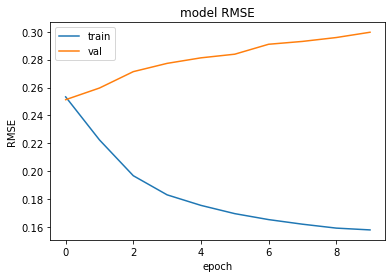

In [47]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Это график плохой модели. Качество на валидационной выборке никак не растет, а это значит мы ничему хорошему не обучаемся. Но не всегда это проблема самой модели. В самих данных может быть недостаточно информации для предсказания (в этом конкретном случае так и есть, это сложно сореванование и текст описания в итоговых моделях не был основным признаком)

Теперь почти тоже самое только в функциональном виде.
Вместо склеивания векторов в один попробуем просто их усреднять.

In [48]:
# input можно не задавать и указывать параметры в эмбединг слое,
# но это может пригодиться, когда мы хотим сделать больше входных слоев
inputs = tf.keras.layers.Input(shape=(100,))


embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs)
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [49]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
         epochs=10)

Epoch 1/10
258/258 [==============================] - 1s 2ms/step - loss: 0.1872 - root_mean_squared_error: 0.4326 - val_loss: 0.1521 - val_root_mean_squared_error: 0.3900
Epoch 2/10
258/258 [==============================] - 0s 2ms/step - loss: 0.1391 - root_mean_squared_error: 0.3728 - val_loss: 0.1010 - val_root_mean_squared_error: 0.3179
Epoch 3/10
258/258 [==============================] - 0s 2ms/step - loss: 0.0925 - root_mean_squared_error: 0.3040 - val_loss: 0.0756 - val_root_mean_squared_error: 0.2749
Epoch 4/10
258/258 [==============================] - 0s 2ms/step - loss: 0.0734 - root_mean_squared_error: 0.2710 - val_loss: 0.0702 - val_root_mean_squared_error: 0.2650
Epoch 5/10
258/258 [==============================] - 1s 3ms/step - loss: 0.0699 - root_mean_squared_error: 0.2644 - val_loss: 0.0694 - val_root_mean_squared_error: 0.2635
Epoch 6/10
258/258 [==============================] - 1s 2ms/step - loss: 0.0696 - root_mean_squared_error: 0.2638 - val_loss: 0.0692 - val_

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


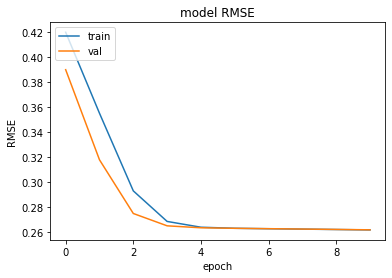

In [50]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

График должен выглядеть как-то так, но разница между начальными и конечными числами должна быть побольше.

Обучать эмбединги под задачу в теории правильнее всего, но на практике бывает лучше использовать предобученные эмбединги (word2vec, fastext, glove). Отдельно эмбединги обучаются быстрее и можно использовать гораздо больше данных, так как нам не нужна разметка.

Обучим фастекст модель.

In [51]:
import gensim

In [15]:
texts = avito.description.apply(preprocess).tolist()

In [23]:
%%time
ft = gensim.models.FastText(texts, vector_size=100)

CPU times: user 2min 3s, sys: 621 ms, total: 2min 4s
Wall time: 46.9 s


In [25]:
ft.wv.most_similar('коляска')

[('➡️коляска', 0.9847369194030762),
 ('коляска-люлька', 0.9759660363197327),
 ('санки-коляска', 0.9555612802505493),
 ('кресло-коляска', 0.9402867555618286),
 ('колясочка', 0.933530330657959),
 ('коляска-трансформер', 0.908164918422699),
 ('коляски', 0.8965704441070557),
 ('колясок', 0.8908169269561768),
 ('коляску-люльку', 0.8881371021270752),
 ('коляске', 0.884643018245697)]

Теперь нам нужно сделать матрицу с векторами. Индексы строчек в этой матрице должны совпадать с индексами слов в словаре.

In [28]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights[i] = ft.wv['опрагпллирао']

In [29]:
inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False,
                                      weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='linear')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [52]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=512,
         epochs=30)

Epoch 1/30
258/258 [==============================] - 1s 2ms/step - loss: 0.0683 - root_mean_squared_error: 0.2614 - val_loss: 0.0684 - val_root_mean_squared_error: 0.2615
Epoch 2/30
258/258 [==============================] - 0s 2ms/step - loss: 0.0682 - root_mean_squared_error: 0.2611 - val_loss: 0.0682 - val_root_mean_squared_error: 0.2611
Epoch 3/30
258/258 [==============================] - 0s 2ms/step - loss: 0.0680 - root_mean_squared_error: 0.2607 - val_loss: 0.0680 - val_root_mean_squared_error: 0.2608
Epoch 4/30
258/258 [==============================] - 0s 2ms/step - loss: 0.0677 - root_mean_squared_error: 0.2603 - val_loss: 0.0678 - val_root_mean_squared_error: 0.2603
Epoch 5/30
258/258 [==============================] - 0s 2ms/step - loss: 0.0675 - root_mean_squared_error: 0.2598 - val_loss: 0.0675 - val_root_mean_squared_error: 0.2599
Epoch 6/30
258/258 [==============================] - 0s 2ms/step - loss: 0.0672 - root_mean_squared_error: 0.2593 - val_loss: 0.0673 - val_

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


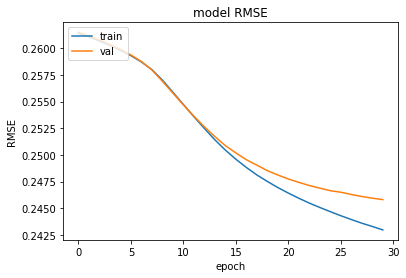

In [53]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Классификация

Теперь проделаем тоже самое с классификацией. 

Данные возьмем из соревнования - https://www.kaggle.com/c/quora-insincere-questions-classification/overview  
В этом соревновании нужно было предсказывать токсичность вопроса.

In [55]:
quora = pd.read_csv('quora.csv')

In [56]:
quora

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


Предобработка точно такая же

In [57]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [58]:
len(vocab)

273056

In [59]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

In [60]:
len(filtered_vocab)

14083

In [61]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [62]:
id2word = {i:word for word, i in word2id.items()}

In [63]:
# переводим тексты в последовательности индексов
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [64]:
MAX_LEN = max(len(x) for x in X)

In [65]:
MAX_LEN

134

Тут уже максимальная длина не такая большая

In [66]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [67]:
X.shape

(1306122, 134)

In [68]:
y = quora.target.values

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

Разлчия в самой модели тоже минимальные - нужно поменять активацию в последнем слое, лосс и метрику.

In [70]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
mean = tf.keras.layers.Flatten()(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


Как выбирать batch_size? Размер батча может влиять на качество модели и точно влияет на скорость обучения. Обычно, чем больше батч, тем быстрее будет обучаться модель. Размер батча ограничен памятью видеокарты, поэтому чем лучше gpu, тем больше может быть batch_size. 

Примерное максимальное значение можно найти быстрым перебором. Если появляется ошибка, то слишком большой batch_size, а если обучается, то можно попробовать поставить побольше.

In [71]:
# как выглядит ошибка при слишком большом батче
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=20000,
         epochs=10)

Epoch 1/10
63/63 [==============================] - 40s 589ms/step - loss: 0.3748 - accuracy: 0.8755 - val_loss: 0.2258 - val_accuracy: 0.9378
Epoch 2/10
63/63 [==============================] - 39s 613ms/step - loss: 0.2237 - accuracy: 0.9380 - val_loss: 0.2198 - val_accuracy: 0.9378
Epoch 3/10
63/63 [==============================] - 39s 616ms/step - loss: 0.2160 - accuracy: 0.9381 - val_loss: 0.2057 - val_accuracy: 0.9378
Epoch 4/10
63/63 [==============================] - 44s 696ms/step - loss: 0.2001 - accuracy: 0.9380 - val_loss: 0.1826 - val_accuracy: 0.9382
Epoch 5/10
63/63 [==============================] - 44s 698ms/step - loss: 0.1766 - accuracy: 0.9390 - val_loss: 0.1600 - val_accuracy: 0.9414
Epoch 6/10
63/63 [==============================] - 43s 675ms/step - loss: 0.1565 - accuracy: 0.9422 - val_loss: 0.1463 - val_accuracy: 0.9443
Epoch 7/10
63/63 [==============================] - 43s 676ms/step - loss: 0.1438 - accuracy: 0.9453 - val_loss: 0.1380 - val_accuracy: 0.9465

In [73]:
# model.fit(X_train, y_train, 
#           validation_data=(X_valid, y_valid),
#           batch_size=512,
#          epochs=10)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


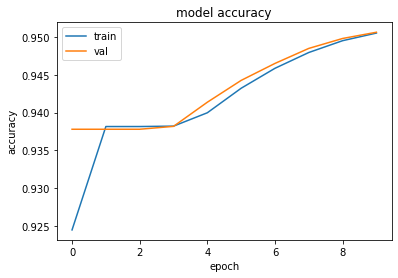

In [74]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Из-за перекоса в классах accuracy не очень честно оценивает модель. F1 меры в tf.keras нет, но можно просто сделать предикт и посчитать через sklearn

In [75]:
from sklearn.metrics import classification_report

In [76]:
preds = model.predict(X_valid).reshape(-1)

In [77]:
# можно подбирать порог для отнесения к токсичному классу
print(classification_report(y_valid, (preds > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     61244
           1       0.68      0.39      0.50      4063

    accuracy                           0.95     65307
   macro avg       0.82      0.69      0.74     65307
weighted avg       0.94      0.95      0.94     65307



## Домашка

1) На одной из задач сравните, что лучше: а) конкатенировать эмбединги в один большой эмбединг, б) усреднять эмбединги, в) складывать эмбединги. Зафиксируйте разбиение на train_test  через random_seed, чтобы обучаться и оцениваться на одних и тех же данных. Параметры нейронок не нужно делать одинаковыми. Просто попробуйте добиться максимума от каждого из подходов. 

2) В одной из задач используйте сразу две предобученные эмбединг модели (можно фастекст и ворд2век, а можно просто 2 фастекста с разными параметрами) в одной нейронке (имеется в виду предобученные до обучения нейронки, т.е вы можете сами обучить фастекст/ворд2век и не искать готовые модели в интернете). Попробуйте усреднять эмбединги и конкатенировать (общие эмбединги потом в один вектор собирайте любым способом - например, тем который оказался лучше в первой задаче).
Подсказка: используйте functional api, сделайте два Embedding слоя и к их выходам примените слой Concatenate([emb1, emb2)) или Average([emb1, emb2))



Бонусный балл можно получить за добавление к пайплайну subword токенизации (через библиотеку tokenizers например)

Лучше делать задание на второй задаче, так как в Авито в любом случае разница будет в несколько десятых процентов.